In [ ]:
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as ds
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import os
import requests
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.models as models
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/dl2')
# Run the models on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Commonly used values for CIFAR10 normalization
mean,std = [0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# Load the data
train_dataset = ds.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testing_dataset = ds.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_dataset,testing_dataset


Mounted at /content/drive
Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ))

In [ ]:
# Split a validation set from test set
test_dataset, val_dataset = random_split(testing_dataset, [5000, 5000])

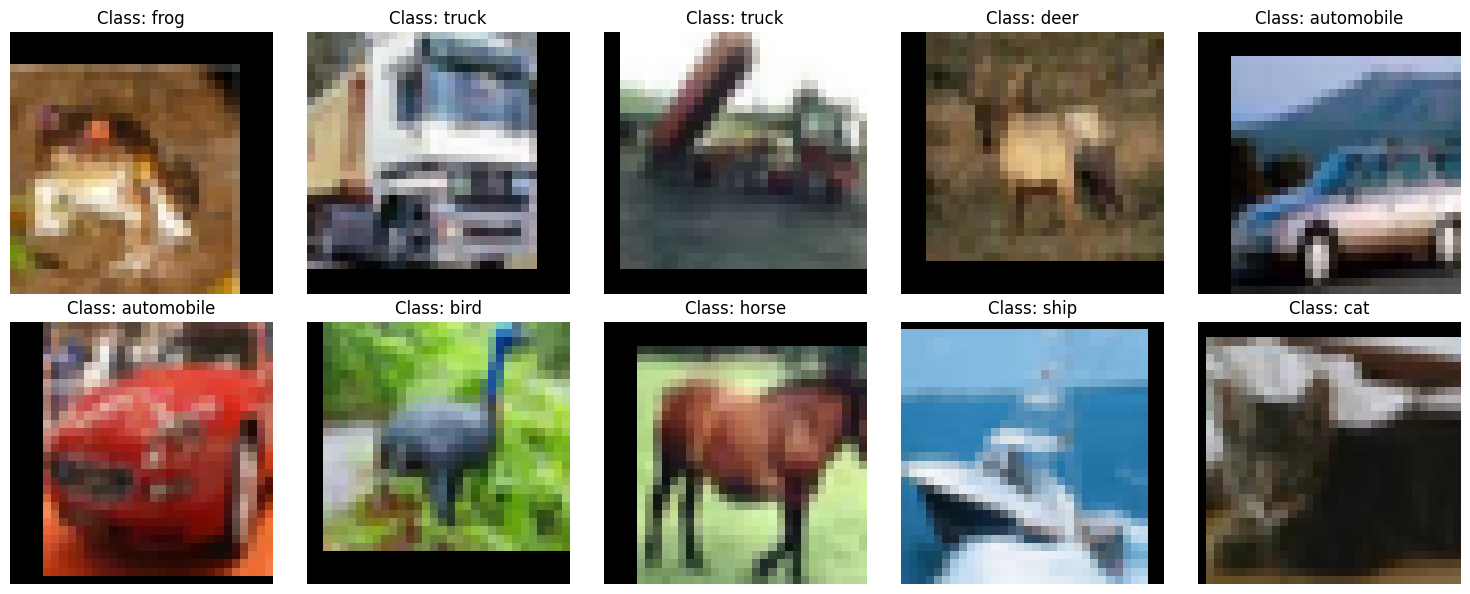

In [ ]:
# Create train, validation, and test sets for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# 10 classes of CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Denormalization
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Display the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    image, label = train_dataset[i]
    image = denormalize(image, mean, std)
    class_name = classes[label]
    ax = axes[i]
    ax.imshow(image.permute(1, 2, 0).clamp(0, 1))  #  ensure values are in [0, 1]
    ax.set_title(f"Class: {class_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):

    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                val_loss = criterion(outputs, y)
                total_val_loss += val_loss.item()

                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        val_accuracy = correct / total
        val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            epochs_no_improve = 0
            best_val_loss = val_loss
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at Epoch {epoch+1}")
                break

    # Plot training and validation loss
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.legend()
    plt.show()

    return model, train_loss_history, val_loss_history


In [ ]:
vgg_model = models.vgg19(pretrained=True)
# change the last layer to 10 classes
vgg_model.classifier[6] = torch.nn.Linear(vgg_model.classifier[6].in_features, 10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 134MB/s]



Training with learning rate: 0.01
Epoch 1/50, Train Loss: 0.8823, Validation Loss: 0.6003, Validation Accuracy: 0.8006
Epoch 2/50, Train Loss: 0.5294, Validation Loss: 0.4924, Validation Accuracy: 0.8418
Epoch 3/50, Train Loss: 0.4376, Validation Loss: 0.4571, Validation Accuracy: 0.8440
Epoch 4/50, Train Loss: 0.3712, Validation Loss: 0.3754, Validation Accuracy: 0.8756
Epoch 5/50, Train Loss: 0.3240, Validation Loss: 0.4008, Validation Accuracy: 0.8728
Epoch 6/50, Train Loss: 0.2892, Validation Loss: 0.3695, Validation Accuracy: 0.8776
Epoch 7/50, Train Loss: 0.2633, Validation Loss: 0.3871, Validation Accuracy: 0.8734
Epoch 8/50, Train Loss: 0.2436, Validation Loss: 0.4039, Validation Accuracy: 0.8744
Epoch 9/50, Train Loss: 0.2219, Validation Loss: 0.3226, Validation Accuracy: 0.8968
Epoch 10/50, Train Loss: 0.2025, Validation Loss: 0.3687, Validation Accuracy: 0.8884
Epoch 11/50, Train Loss: 0.1909, Validation Loss: 0.3837, Validation Accuracy: 0.8762
Epoch 12/50, Train Loss: 0.1

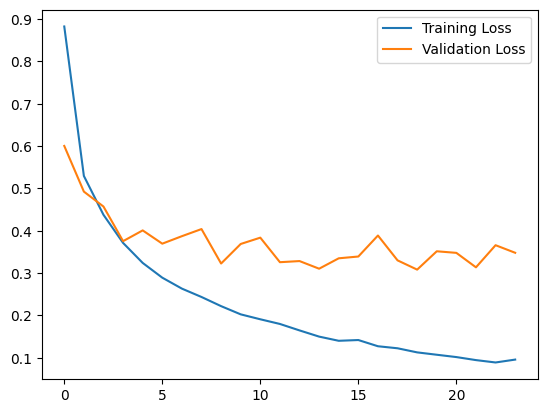

Accuracy of the model on the test dataset: 90.34%


In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
print(f"\nTraining with learning rate: {lr}")

model = vgg_model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
_, _, _ = train_model(model, train_loader, val_loader, criterion, optimizer)

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        all_labels.extend(y.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f"Accuracy of the model on the test dataset: {100 * correct / total:.2f}%")


In [ ]:
# Classification report
report = classification_report(all_labels, all_predictions, target_names=classes, output_dict=True)
for class_name, metrics in report.items():
    if class_name in classes:
        print(f"Accuracy for {class_name}: {metrics['precision']:.2f}, Correctly Predicted: {metrics['support']*metrics['precision']:.0f}/{metrics['support']}")



Accuracy for airplane: 0.87, Correctly Predicted: 436/502
Accuracy for automobile: 0.94, Correctly Predicted: 472/504
Accuracy for bird: 0.86, Correctly Predicted: 416/482
Accuracy for cat: 0.89, Correctly Predicted: 460/516
Accuracy for deer: 0.96, Correctly Predicted: 488/511
Accuracy for dog: 0.78, Correctly Predicted: 379/485
Accuracy for frog: 0.94, Correctly Predicted: 477/506
Accuracy for horse: 0.89, Correctly Predicted: 456/511
Accuracy for ship: 0.96, Correctly Predicted: 453/473
Accuracy for truck: 0.96, Correctly Predicted: 491/510


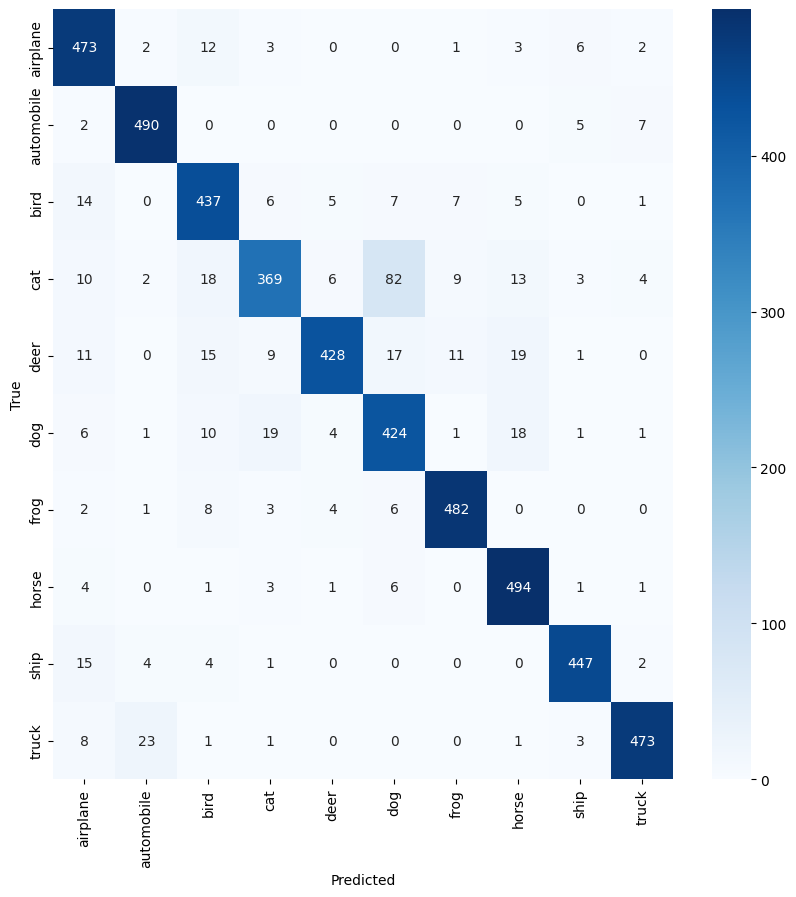

In [ ]:
# Plotting the heatmap
confusion_mtx = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 10))
sn.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
           xticklabels=classes,
           yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()